### Обработка данных

Загрузим необходимые библиотеки и настройки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим датафрейм и изучим данные

In [ ]:
data = pd.read_excel('/content/data.xlsx')

In [ ]:
data.head()

,client_id,sum,status,sale,new/current,Unnamed: 5,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN,NaN
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,NaN,-,-
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,NaN,оригинал,2021-07-26 00:00:00
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,2021-06-08 00:00:00
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,2021-06-08 00:00:00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       724 non-null    float64
 1   sum             724 non-null    float64
 2   status          730 non-null    object 
 3   sale            724 non-null    object 
 4   new/current     724 non-null    object 
 5   Unnamed: 5      0 non-null      float64
 6   document        709 non-null    object 
 7   receiving_date  607 non-null    object 
dtypes: float64(3), object(5)
memory usage: 45.8+ KB


Можно сделать следующие выводы:

*   Присутствует пустой столбец, который необходимо удалить
*   Дату получения оригинальных документов необходимо перевести в формат datetime
*   Необходимо перенести строку, сигнализирующую о принадлежности сделки к определенному месяцу к новому столбцу
*   Необходимо проверить пропуски и потенциальные дубликаты



Уберем пустой столбец

In [ ]:
data = data[data.filter(regex='^(?!Unnamed)').columns]

Перенесем строку, сигнализирующую о принадлежности сделки к определенному месяцу к новому столбцу

In [ ]:
data.query('client_id.isnull()')['status'].unique()

array(['Май 2021', 'Июнь 2021', 'Июль 2021', 'Август 2021',
       'Сентябрь 2021', 'Октябрь 2021'], dtype=object)

In [ ]:
mask = data['status'].isin(data.query('client_id.isnull()')['status'].unique())
data['temp'] = mask.cumsum()

In [ ]:
data.head()

,client_id,sum,status,sale,new/current,document,receiving_date,temp
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN,1
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,-,-,1
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,1
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,1
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,1


In [ ]:
def month(row):
  if row['temp']==1:
    return 'Май 2021'
  if row['temp']==2:
    return 'Июнь 2021'
  if row['temp']==3:
    return 'Июль 2021'
  if row['temp']==4:
    return 'Август 2021'
  if row['temp']==5:
    return 'Сентябрь 2021'
  if row['temp']==6:
    return 'Октябрь 2021'

In [ ]:
data['month'] = data.apply(month, axis=1)
data = data.drop('temp', axis=1)

In [ ]:
### дополнительно уберу сделку со статусом "Внутренний", т.к. она единственная в датафрейме
for_drop = data.query('client_id.isnull() or status=="ВНУТРЕННИЙ"').index

In [ ]:
r_data = data.drop(for_drop)

In [ ]:
r_data.head(5)

,client_id,sum,status,sale,new/current,document,receiving_date,month
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,Май 2021
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,Май 2021
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,Май 2021
5,18.0,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00,Май 2021
6,20.0,5796.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-07-15 00:00:00,Май 2021


In [ ]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 723 entries, 2 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       723 non-null    float64
 1   sum             723 non-null    float64
 2   status          723 non-null    object 
 3   sale            723 non-null    object 
 4   new/current     723 non-null    object 
 5   document        708 non-null    object 
 6   receiving_date  606 non-null    object 
 7   month           723 non-null    object 
dtypes: float64(2), object(6)
memory usage: 67.0+ KB


In [ ]:
### В связи с проблемой к подключению к Locale, создадим вручную словарь месяцов на кирилице
month_map = {
    'Январь': 1, 'Февраль': 2, 'Март': 3, 'Апрель': 4, 'Май': 5, 'Июнь': 6,
    'Июль': 7, 'Август': 8, 'Сентябрь': 9, 'Октябрь': 10, 'Ноябрь': 11, 'Декабрь': 12
}

def convert_date(date_str):
  month, year = date_str.split()
  month = month_map[month]
  return pd.to_datetime(f'{year}-{month}')


r_data['receiving_date'] = pd.to_datetime(r_data['receiving_date'])
r_data['month'] = r_data['month'].apply(convert_date)

In [ ]:
r_data.head()

,client_id,sum,status,sale,new/current,document,receiving_date,month
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26,2021-05-01
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08,2021-05-01
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08,2021-05-01
5,18.0,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07,2021-05-01
6,20.0,5796.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-07-15,2021-05-01


In [ ]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 723 entries, 2 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       723 non-null    float64       
 1   sum             723 non-null    float64       
 2   status          723 non-null    object        
 3   sale            723 non-null    object        
 4   new/current     723 non-null    object        
 5   document        708 non-null    object        
 6   receiving_date  606 non-null    datetime64[ns]
 7   month           723 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 67.0+ KB


Проверим дубликаты

In [ ]:
r_data[r_data.duplicated(keep=False)]

,client_id,sum,status,sale,new/current,document,receiving_date,month
18,43.0,1961.2,ОПЛАЧЕНО,Селиванов,текущая,оригинал,2021-07-27,2021-05-01
19,43.0,1961.2,ОПЛАЧЕНО,Селиванов,текущая,оригинал,2021-07-27,2021-05-01
52,96.0,1266.2,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-07-16,2021-05-01
53,96.0,1266.2,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-07-16,2021-05-01
97,204.0,1473.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-07-01,2021-05-01
98,204.0,1473.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-07-01,2021-05-01
179,97.0,1506.2,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-09-01,2021-06-01
180,97.0,1506.2,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-09-01,2021-06-01
223,204.0,1523.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-07-21,2021-06-01
224,204.0,1523.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-07-21,2021-06-01


Видим дубликаты, где подряд идет двойной учет одних и тех же записей. Удалим дубликаты

In [ ]:
r_data = r_data.drop_duplicates()

Проверим пропуски

In [ ]:
r_data[r_data['document'].isnull()]

,client_id,sum,status,sale,new/current,document,receiving_date,month
47,87.0,9948.7,ОПЛАЧЕНО,Смирнов,новая,NaN,2021-06-17,2021-05-01
48,90.0,16123.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-07-28,2021-05-01
49,91.0,1053.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-07-28,2021-05-01
93,198.0,4458.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-07-01,2021-05-01
189,115.0,298.7,ОПЛАЧЕНО,Андреев,текущая,NaN,2021-07-14,2021-06-01
337,228.0,2193.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-10-06,2021-07-01
376,32.0,7101.7,ОПЛАЧЕНО,Филимонова,текущая,NaN,2021-10-06,2021-08-01
409,90.0,8454.2,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-09-20,2021-08-01
453,339.0,7553.7,ОПЛАЧЕНО,Петрова,новая,NaN,2021-10-11,2021-08-01
459,256.0,2351.2,ОПЛАЧЕНО,Филимонова,текущая,NaN,NaT,2021-08-01


На основании данных, можно заполнить эти пропуски следующим образом:


*   Если даты получения оригинала не стоит, ставим "НЕТ"
*   Если дата получения оригинала стоит, ставим "оригинал"



In [ ]:
def fill_document(row):
  if pd.isnull(row['receiving_date']):
    return 'НЕТ'
  else:
    return 'оригинал'

r_data['document'] = r_data.apply(lambda row: fill_document(row) if pd.isnull(row['document']) else row['document'], axis=1)

Пропуски в столбце receiving date стоят, если нет даты поступления оригинала. Оставляем пропуски

Проверим аномальные значения. Учитывая структуру датафрейма, будем проверять аномальные значения столбца Sum

In [ ]:
r_data['sum'].describe()

,sum
count,709.000000
mean,7218.977334
std,6266.507193
min,23.700000
25%,3238.700000
50%,5328.700000
75%,8973.700000
max,39713.500000


Проверим 99 процентиль

In [ ]:
r_data[r_data['sum']>=r_data['sum'].quantile(0.99)]

,client_id,sum,status,sale,new/current,document,receiving_date,month
108,244.0,32498.5,ОПЛАЧЕНО,Смирнов,текущая,оригинал,2021-06-10,2021-05-01
130,316.0,35653.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-08-09,2021-06-01
234,244.0,32498.5,ОПЛАЧЕНО,Смирнов,текущая,оригинал,2021-07-22,2021-06-01
302,112.0,39713.5,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-09-08,2021-07-01
341,244.0,32498.5,ОПЛАЧЕНО,Смирнов,текущая,оригинал,2021-08-23,2021-07-01
454,244.0,32498.5,ОПЛАЧЕНО,Смирнов,текущая,оригинал,2021-09-03,2021-08-01
565,244.0,32498.5,ОПЛАЧЕНО,Смирнов,текущая,оригинал,2021-10-15,2021-09-01
694,244.0,32498.5,ОПЛАЧЕНО,Смирнов,текущая,НЕТ,NaT,2021-10-01


Можем сделать вывод, что большинство аномально больших заказов осуществляются одним клиентом через одного менеджера с периодичностью раз в месяц. Таким образом, эти заказы отражают картину деятельности и остаются в датафрейме

**Данные обработаны и готовы к выполнению поставленных задач**

In [ ]:
r_data.head()

,client_id,sum,status,sale,new/current,document,receiving_date,month
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26,2021-05-01
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08,2021-05-01
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08,2021-05-01
5,18.0,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07,2021-05-01
6,20.0,5796.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-07-15,2021-05-01


In [ ]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 709 entries, 2 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       709 non-null    float64       
 1   sum             709 non-null    float64       
 2   status          709 non-null    object        
 3   sale            709 non-null    object        
 4   new/current     709 non-null    object        
 5   document        709 non-null    object        
 6   receiving_date  594 non-null    datetime64[ns]
 7   month           709 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 49.9+ KB


### Вопросы

#### Вопрос 1

Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных
средств которых не просрочен.

In [ ]:
r_data.query('month=="2021-07-01" and status!= "ПРОСРОЧЕНО"').groupby('month')['sum'].sum()

,sum
month,
2021-07-01,852012.87


Общая выручка за июль 2021 года по непросроченым сделкам составляет 852 012,87 рублей

#### Вопрос 2
Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.

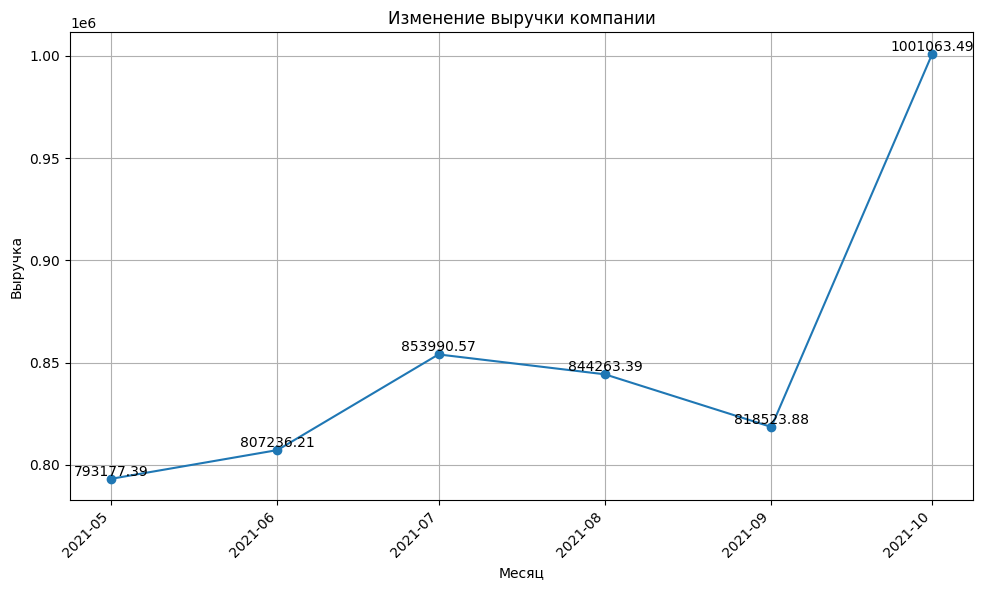

In [ ]:
monthly_revenue = r_data.groupby('month')['sum'].sum()

plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o', linestyle='-')

for month, revenue in monthly_revenue.items():
    plt.text(month, revenue, f'{revenue:.2f}', ha='center', va='bottom')

plt.title('Изменение выручки компании')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Можно сделать вывод, что в период с мая по июль наблюдается рост выручки, после чего она незначительно уменьшается и в октябре делает скачек к показателю ~1млн рублей

#### Вопрос 3

Кто из менеджеров привлек для компании больше всего денежных средств в
сентябре 2021?

In [ ]:
r_data.query('month=="2021-09-01"').groupby('sale')['sum'].sum().sort_values(ascending=False)

,sum
sale,
Смирнов,220672.00
Петрова,149344.46
Андреев,132646.30
Иванов,94770.60
Кузнецова,72228.40
Филимонова,59514.47
Васильев,49895.45
Соколов,35183.50
Михайлов,4268.70


В данном периоде больше всего средств для компании привлек менеджер Смирнов

#### Вопрос 4
Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

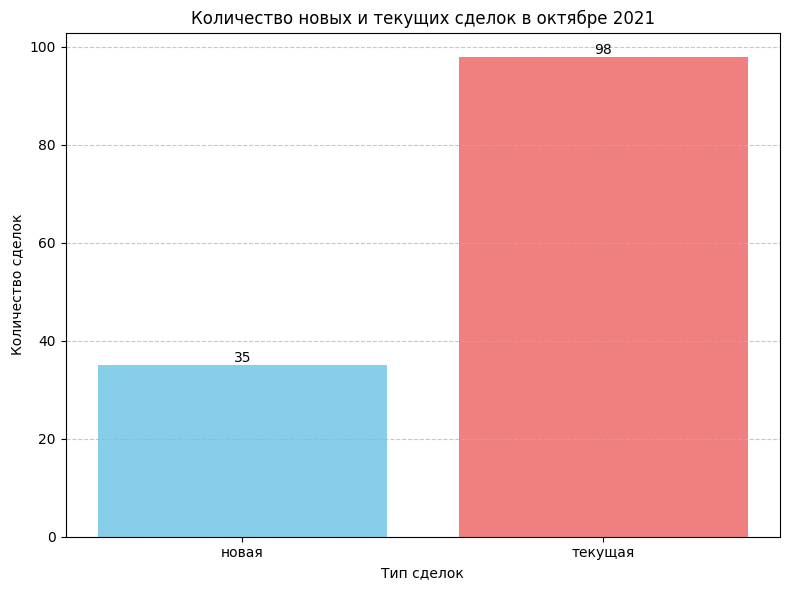

In [ ]:
new_current_counts = r_data.query('month == "2021-10-01"').groupby('new/current')['new/current'].count()

plt.figure(figsize=(8, 6))
bars = plt.bar(new_current_counts.index, new_current_counts.values, color=['skyblue', 'lightcoral'])

# Add labels and title
plt.xlabel("Тип сделок")
plt.ylabel("Количество сделок")
plt.title("Количество новых и текущих сделок в октябре 2021")

# Add value labels to the bars
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Customize the appearance
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

В рассматриваемом периоде преобладающим типом сделок являются текущие

#### Вопрос 5
Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [ ]:
temp_r_data = r_data.copy()
temp_r_data['r_date_month'] = r_data['receiving_date'].dt.month_name()

In [ ]:
temp_r_data.query('month=="2021-05-01"').groupby('r_date_month')['receiving_date'].count()

,receiving_date
r_date_month,
August,1
July,37
June,77
May,3
October,2
September,4


В июне было получено 77 оригиналов договоров по майским сделкам

### Задание

За каждую заключенную сделку менеджер получает бонус, который рассчитывается
следующим образом.

1.   За новые сделки менеджер получает 7 % от суммы, при условии, что статус
оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с
клиентом (в рассматриваемом месяце).
2.   За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного договора с клиентом (в рассматриваемом месяце).

Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого
месяца, считаются остатком на следующий период, который выплачивается по мере
прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021.

Зададим функцию, которая будет рассчитывать остаток на начало июля и выведем таблицу по менеджерам

In [ ]:
def bonus(row):
  if row['receiving_date'].month-row['month'].month==1:
    return 0
  if row['new/current']=="новая" and row['status']=='ОПЛАЧЕНО' and row['receiving_date'].month>row['month'].month:
    return row['sum']*0.07
  if row['new/current']=="текущая" and row['status']!="ПРОСРОЧЕНО" and row['receiving_date'].month>row['month'].month:
    if row['sum']>10000:
      return row['sum']*0.05
    else:
      return row['sum']*0.03
  else:
    return 0

In [ ]:
task_data = r_data.copy()
task_data = task_data.query('month<="2021-06-01"')
task_data['bonus'] = task_data.apply(bonus, axis=1)

In [ ]:
task_data.groupby('sale')['bonus'].sum().sort_values(ascending=False)

,bonus
sale,
Петрова,6379.4320
Иванов,3602.0670
Смирнов,2292.6790
Кузнецова,2199.0716
Селиванов,1871.4720
Филимонова,1799.5769
Андреев,807.1680
Васильев,578.3940
Соколов,269.2110


Можно сделать вывод, что на начало Июля наибольший остаток у менеджера Петровой в размере 6379,44 рублей, а наименьший - у Соколова в размере 269,21 рубль